# Vertical takeoff and landing aircraft

This notebook demonstrates the use of the python-control package for analysis and design of a controller for a vectored thrust aircraft model that is used as a running example through the text *Feedback Systems* by Astrom and Murray. This example makes use of MATLAB compatible commands. 

Additional information on this system is available at

http://www.cds.caltech.edu/~murray/wiki/index.php/Python-control/Example:_Vertical_takeoff_and_landing_aircraft

## System Description
This example uses a simplified model for a (planar) vertical takeoff and landing aircraft (PVTOL), as shown below:

![PVTOL diagram](http://www.cds.caltech.edu/~murray/wiki/images/7/7d/Pvtol-diagram.png)

![PVTOL dynamics](http://www.cds.caltech.edu/~murray/wiki/images/b/b7/Pvtol-dynamics.png)

The position and orientation of the center of mass of the aircraft is denoted by $(x,y,\theta)$,  $m$ is the mass of the vehicle, $J$ the moment of inertia, $g$ the gravitational constant and $c$ the damping coefficient. The forces generated by the main downward thruster and the maneuvering thrusters are modeled as a pair of forces $F_1$ and $F_2$ acting at a distance $r$ below the aircraft (determined by the geometry of the thrusters).

Letting $z=(x,y,\theta, \dot x, \dot y, \dot\theta$), the equations can be written in state space form as:
$$
\frac{dz}{dt} = \begin{bmatrix}
                       z_4 \\
                       z_5 \\
                       z_6 \\
                       -\frac{c}{m} z_4 \\
                       -g- \frac{c}{m} z_5 \\
                       0
                  \end{bmatrix}
                  +
                  \begin{bmatrix}
                       0 \\
                       0 \\
                       0 \\
                       \frac{1}{m} \cos \theta F_1 + \frac{1}{m} \sin \theta F_2 \\
                       \frac{1}{m} \sin \theta F_1 + \frac{1}{m} \cos \theta F_2 \\
                       \frac{r}{J} F_1
                  \end{bmatrix}
$$

## LQR state feedback controller
This section demonstrates the design of an LQR state feedback controller for the vectored thrust aircraft example. This example is pulled from Chapter 6 (Linear Systems, Example 6.4) and Chapter 7 (State Feedback, Example 7.9) of [Astrom and Murray](https://fbsbook.org). The python code listed here are contained the the file pvtol-lqr.py.

To execute this example, we first import the libraries for SciPy, MATLAB plotting and the python-control package:

In [1]:
from numpy import *             # Grab all of the NumPy functions
from matplotlib.pyplot import * # Grab MATLAB plotting functions
from control.matlab import *    # MATLAB-like functions
%matplotlib inline

The parameters for the system are given by

In [2]:
m = 4                         # mass of aircraft
J = 0.0475                    # inertia around pitch axis
r = 0.25                      # distance to center of force
g = 9.8                       # gravitational constant
c = 0.05                      # damping factor (estimated)

Choosing equilibrium inputs to be $u_e = (0, mg)$, the dynamics of the system $\frac{dz}{dt}$, and their linearization $A$ about equilibrium point $z_e = (0, 0, 0, 0, 0, 0)$ are given by
$$
\frac{dz}{dt} = \begin{bmatrix}
                       z_4 \\
                       z_5 \\
                       z_6 \\
                       -g \sin z_3 -\frac{c}{m} z_4 \\
                       g(\cos z_3 - 1)- \frac{c}{m} z_5 \\
                       0
                  \end{bmatrix}
\qquad
A = \begin{bmatrix}
       0 & 0 & 0 &1&0&0\\
       0&0&0&0&1&0 \\
       0&0&0&0&0&1 \\
       0&0&-g&-c/m&0&0 \\
       0&0&0&0&-c/m&0 \\
       0&0&0&0&0&0
    \end{bmatrix}
$$

In [3]:
# State space dynamics
xe = [0, 0, 0, 0, 0, 0]         # equilibrium point of interest
ue = [0, m*g]                   # (note these are lists, not matrices)

In [4]:
# Dynamics matrix (use matrix type so that * works for multiplication)
# Note that we write A and B here in full generality in case we want
# to test different xe and ue.
A = matrix(
   [[ 0,    0,    0,    1,    0,    0],
    [ 0,    0,    0,    0,    1,    0],
    [ 0,    0,    0,    0,    0,    1],
    [ 0, 0, (-ue[0]*sin(xe[2]) - ue[1]*cos(xe[2]))/m, -c/m, 0, 0],
    [ 0, 0, (ue[0]*cos(xe[2]) - ue[1]*sin(xe[2]))/m, 0, -c/m, 0],
    [ 0,    0,    0,    0,    0,    0 ]])

# Input matrix
B = matrix(
   [[0, 0], [0, 0], [0, 0],
    [cos(xe[2])/m, -sin(xe[2])/m],
    [sin(xe[2])/m,  cos(xe[2])/m],
    [r/J, 0]])

# Output matrix 
C = matrix([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
D = matrix([[0, 0], [0, 0]])

To compute a linear quadratic regulator for the system, we write the cost function as
$$ J = \int_0^\infty (\xi^T Q_\xi \xi + v^T Q_v v) dt,$$

where $\xi = z - z_e$ and $v = u - u_e$ represent the local coordinates around the desired equilibrium point $(z_e, u_e)$. We begin with diagonal matrices for the state and input costs:

In [5]:
Qx1 = diag([1, 1, 1, 1, 1, 1])
Qu1a = diag([1, 1])
(K, X, E) = lqr(A, B, Qx1, Qu1a); K1a = matrix(K)

This gives a control law of the form $v = -K \xi$, which can then be used to derive the control law in terms of the original variables:


  $$u = v + u_e = - K(z - z_d) + u_d.$$
where $u_e = (0, mg)$ and $z_d = (x_d, y_d, 0, 0, 0, 0)$

The way we setup the dynamics above, $A$ is already hardcoding $u_d$, so we don't need to include it as an external input. So we just need to cascade the $-K(z-z_d)$ controller with the PVTOL aircraft's dynamics to control it. For didactic purposes, we will cheat in two small ways:

- First, we will only interface our controller with the linearized dynamics. Using the nonlinear dynamics would require the `NonlinearIOSystem` functionalities, which we leave to another notebook to introduce.
2. Second, as written, our controller requires full state feedback ($K$ multiplies full state vectors $z$), which we do not have access to because our system, as written above, only returns $x$ and $y$ (because of $C$ matrix). Hence, we would need a state observer, such as a Kalman Filter, to track the state variables. Instead, we assume that we have access to the full state.

The following code implements the closed loop system:

In [6]:
# Our input to the system will only be (x_d, y_d), so we need to
# multiply it by this matrix to turn it into z_d.
Xd = matrix([[1,0,0,0,0,0],
             [0,1,0,0,0,0]]).T

# Closed loop dynamics
H = ss(A-B*K,B*K*Xd,C,D)

# Step response for the first input
x,t = step(H,input=0,output=0,T=linspace(0,10,100))
# Step response for the second input
y,t = step(H,input=1,output=1,T=linspace(0,10,100))

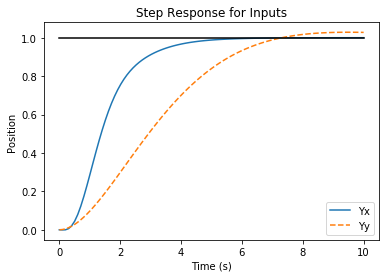

In [7]:
plot(t,x,'-',t,y,'--')
plot([0, 10], [1, 1], 'k-')
ylabel('Position')
xlabel('Time (s)')
title('Step Response for Inputs')
legend(('Yx', 'Yy'), loc='lower right')
show()

The plot above shows the $x$ and $y$ positions of the aircraft when it is commanded to move 1 m in each direction. The following shows the $x$ motion for control weights $\rho = 1, 10^2, 10^4$. A higher weight of the input term in the cost function causes a more sluggish response. It is created using the code:

In [8]:
# Look at different input weightings
Qu1a = diag([1, 1])
K1a, X, E = lqr(A, B, Qx1, Qu1a)
H1ax = H = ss(A-B*K1a,B*K1a*Xd,C,D)

Qu1b = (40**2)*diag([1, 1])
K1b, X, E = lqr(A, B, Qx1, Qu1b)
H1bx = H = ss(A-B*K1b,B*K1b*Xd,C,D)

Qu1c = (200**2)*diag([1, 1])
K1c, X, E = lqr(A, B, Qx1, Qu1c)
H1cx = ss(A-B*K1c,B*K1c*Xd,C,D)

[Y1, T1] = step(H1ax, T=linspace(0,10,100), input=0,output=0)
[Y2, T2] = step(H1bx, T=linspace(0,10,100), input=0,output=0)
[Y3, T3] = step(H1cx, T=linspace(0,10,100), input=0,output=0)

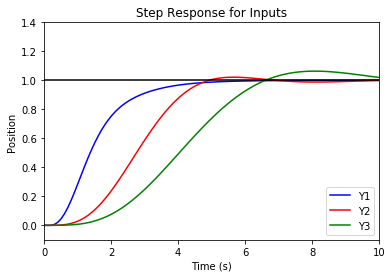

In [9]:
plot(T1, Y1.T, 'b-', T2, Y2.T, 'r-', T3, Y3.T, 'g-')
plot([0 ,10], [1, 1], 'k-')
title('Step Response for Inputs')
ylabel('Position')
xlabel('Time (s)')
legend(('Y1','Y2','Y3'),loc='lower right')
axis([0, 10, -0.1, 1.4])
show()

## Lateral control using inner/outer loop design
This section demonstrates the design of loop shaping controller for the vectored thrust aircraft example. This example is pulled from Chapter 11 (Frequency Domain Design) of [Astrom and Murray](https://fbsbook.org). 

To design a controller for the lateral dynamics of the vectored thrust aircraft, we make use of a "inner/outer" loop design methodology. We begin by representing the dynamics using the block diagram

<img src=http://www.cds.caltech.edu/~murray/wiki/images/3/3f/Pvtol-lateraltf.png>
where
<img src=http://www.cds.caltech.edu/~murray/wiki/images/math/3/6/4/364e56f7893637e12edb0e0ac6c45722.png>  
The controller is constructed by splitting the process dynamics and controller into two components: an inner loop consisting of the roll dynamics $P_i$ and control $C_i$ and an outer loop consisting of the lateral position dynamics $P_o$ and controller $C_o$.
<img src=http://www.cds.caltech.edu/~murray/wiki/images/f/f1/Pvtol-nested-1.png>
The closed inner loop dynamics $H_i$ control the roll angle of the aircraft using the vectored thrust while the outer loop controller $C_o$ commands the roll angle to regulate the lateral position.

The following code imports the libraries that are required and defines the dynamics:

In [10]:
from matplotlib.pyplot import * # Grab MATLAB plotting functions
from control.matlab import *    # MATLAB-like functions

In [12]:
# System parameters
m = 4                         # mass of aircraft
J = 0.0475                    # inertia around pitch axis
r = 0.25                      # distance to center of force
g = 9.8                       # gravitational constant
c = 0.05                      # damping factor (estimated)

In [13]:
# Transfer functions for dynamics
Pi = tf([r], [J, 0, 0])       # inner loop (roll)
Po = tf([1], [m, c, 0])       # outer loop (position)

For the inner loop, use a lead compensator

In [14]:
k = 200
a = 2
b = 50
Ci = k*tf([1, a], [1, b])     # lead compensator
Li = Pi*Ci

The closed loop dynamics of the inner loop, $H_i$, are given by

In [15]:
Hi = parallel(feedback(Ci, Pi), -m*g*feedback(Ci*Pi, 1))

Finally, we design the lateral compensator using another lead compenstor

In [16]:
# Now design the lateral control system
a = 0.02
b = 5
K = 2
Co = -K*tf([1, 0.3], [1, 10])         # another lead compensator
Lo = -m*g*Po*Co

The performance of the system can be characterized using the sensitivity function and the complementary sensitivity function:

In [17]:
L = Co*Hi*Po
S = feedback(1, L)
T = feedback(L, 1)

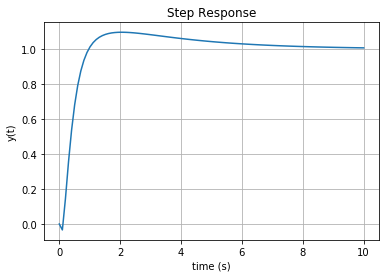

In [18]:
t, y = step(T, T=linspace(0,10,100))
plot(y, t)
title("Step Response")
grid()
xlabel("time (s)")
ylabel("y(t)")
show()

The frequency response and Nyquist plot for the loop transfer function are computed using the commands

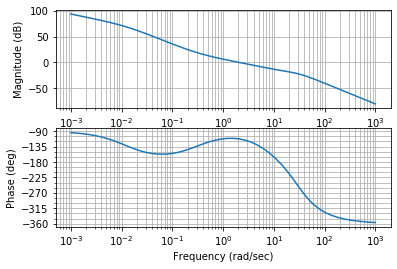

In [19]:
bode(L)
show()

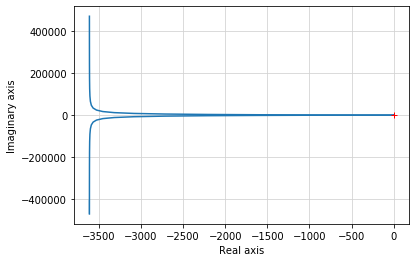

In [20]:
nyquist(L, (0.0001, 1000))
show()

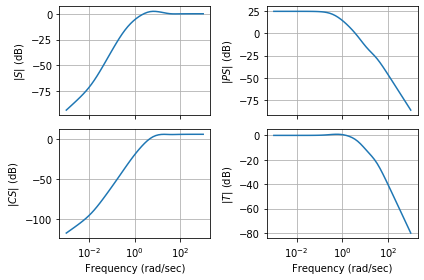

In [21]:
gangof4(Hi*Po, Co)